<a href="https://colab.research.google.com/github/YonggunJung/ICT_TensorFlow/blob/main/20231004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip /content/cat_dog_small.zip

Archive:  /content/cat_dog_small.zip
   creating: test/
   creating: test/cats/
  inflating: test/cats/cat.1500.jpg  
  inflating: test/cats/cat.1501.jpg  
  inflating: test/cats/cat.1502.jpg  
  inflating: test/cats/cat.1503.jpg  
  inflating: test/cats/cat.1504.jpg  
  inflating: test/cats/cat.1505.jpg  
  inflating: test/cats/cat.1506.jpg  
  inflating: test/cats/cat.1507.jpg  
  inflating: test/cats/cat.1508.jpg  
  inflating: test/cats/cat.1509.jpg  
  inflating: test/cats/cat.1510.jpg  
  inflating: test/cats/cat.1511.jpg  
  inflating: test/cats/cat.1512.jpg  
  inflating: test/cats/cat.1513.jpg  
  inflating: test/cats/cat.1514.jpg  
  inflating: test/cats/cat.1515.jpg  
  inflating: test/cats/cat.1516.jpg  
  inflating: test/cats/cat.1517.jpg  
  inflating: test/cats/cat.1518.jpg  
  inflating: test/cats/cat.1519.jpg  
  inflating: test/cats/cat.1520.jpg  
  inflating: test/cats/cat.1521.jpg  
  inflating: test/cats/cat.1522.jpg  
  inflating: test/cats/cat.1523.jpg  
  inflat

In [2]:
# Pretrained Network 이용
# VGG16 모델 이용

from tensorflow.keras.applications import VGG16


# weights = 'imagenet' => 이미지넷 데이터셋으로 학습된 모델을 불러오기
# include_top = False => 모델의 FC Layer(Classifier)부분을 포함할지 말지 결정
# False는 미포함, 일반적으로 미포함
# input_shape = (150, 150, 3) => 네트워크에 주입할 이미지의 shape
model_base = VGG16(weights='imagenet',
                   include_top = False,
                   input_shape = (150, 150, 3))

model_base.summary()

# 원래 VGG16 모델의 예측값은 당연히 class에 대한 확률값
# include_top = False로 설정해서 classifier를 없앴기 때문에 해당모델의 예측값은 이미지의 특성을 추출한 데이터가 될꺼임

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [6]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/train'
validation_dir = '/content/validation'

datagen = ImageDataGenerator(rescale = 1/255)
batch_size = 20

def extract_feature(diretory, sample_count):
    features = np.zeros(shape=(sample_count,4,4,512))
    labels = np.zeros(shape=(sample_count,))

    generator = datagen.flow_from_directory(
        diretory,
        target_size = (150, 150),
        batch_size = batch_size,
        class_mode = 'binary'
    )

    i = 0

    for x_data_batch, t_data_batch in generator:
        feature_batch = model_base.predict(x_data_batch)
        features[i*batch_size:(i+1)*batch_size] = feature_batch
        labels[i*batch_size:(i+1)*batch_size] = t_data_batch

        i += 1
        if i * batch_size >= sample_count:
            break;

    return features, labels


train_features, train_labels = extract_feature(train_dir,2000)
validation_features, validation_labels = extract_feature(validation_dir,1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 35ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 24ms/step


In [12]:
# 이미지의 특성이 추출된 데이터가 준비됨
# 학습
# DNN으로 처리

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Flatten(input_shape = (4*4*512,)))  # 위쪽의 features = np.zeros(shape=(sample_count,4,4,512)) 이걸 펴주는거
model.add(Dense(units = 256,
                activation = 'relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(units = 1,
                activation = 'sigmoid'))

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

x_data = np.reshape(train_features, (2000,4 * 4 * 512))
t_data = train_labels

valid_x_data = np.reshape(validation_features, (1000,4 * 4 * 512))
valid_t_data = validation_labels

history = model.fit(x_data,
                    t_data,
                    epochs=30,
                    batch_size=20,
                    validation_data=(valid_x_data, valid_t_data))


Epoch 1/30
100/100 [==============================] - 3s 7ms/step - loss: 0.4447 - accuracy: 0.7745 - val_loss: 0.3918 - val_accuracy: 0.8050
Epoch 2/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2732 - accuracy: 0.8905 - val_loss: 0.2579 - val_accuracy: 0.9010
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2269 - accuracy: 0.9175 - val_loss: 0.2449 - val_accuracy: 0.9030
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.1826 - accuracy: 0.9280 - val_loss: 0.2797 - val_accuracy: 0.8770
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.1684 - accuracy: 0.9370 - val_loss: 0.2381 - val_accuracy: 0.9060
Epoch 6/30
100/100 [==============================] - 0s 5ms/step - loss: 0.1348 - accuracy: 0.9545 - val_loss: 0.2432 - val_accuracy: 0.8950
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.1265 - accuracy: 0.9550 - val_loss: 0.2396 - val_accuracy: 0.8990
Epoch 

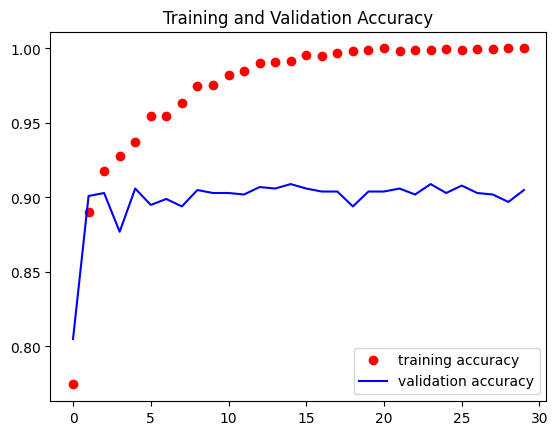

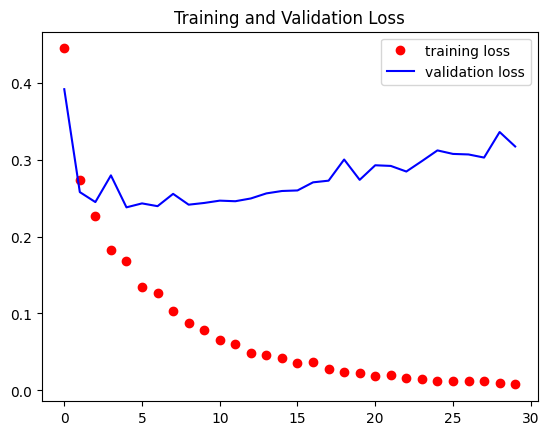

In [13]:
# 결과 그래프

import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_acc, 'o', color='r', label='training accuracy')
plt.plot(val_acc, color='b', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, 'o', color='r', label='training loss')
plt.plot(val_loss, color='b', label='validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# 처리 결과
# 먼저 Accuracy는 4000개의 데이터를 이용했음에도 불구하고 좋아졌음
# 그리고 학습의 속도 역시 빼우 빨리졌음 (convolution layer를 매 epoch마다 거치지 않아서)
# 하지만 overfitting이 많이 심해졌음 (데이터의 부재)

# 자 그러면 일단 overfitting부터 해결 => 증식으로 해결



In [20]:
# 증식까지 포함한 Pretrained Network를 이용한 개와 고양이 분류

import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


train_dir = '/content/train'
validation_dir = '/content/validation'

train_datagen = ImageDataGenerator(rescale = 1/255,
                                   rotation_range = 30,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip =True)

validation_datagen = ImageDataGenerator(rescale = 1/255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes = ['cats', 'dogs'],
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes = ['cats', 'dogs'],
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

# Pretrained Network Loading
model_base = VGG16(weights = 'imagenet',
                   include_top = False,
                   input_shape = (150, 150, 3))

model_base.trainable = False  # Convolution Layer를 동결

model = Sequential()

model.add(model_base)

model.add(Flatten(input_shape = (4*4*512,)))

model.add(Dense(units = 256,
                activation = 'relu'))

model.add(Dropout(rate = 0.5))

model.add(Dense(units = 1,
                activation = 'sigmoid'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(train_generator,
                    steps_per_epoch = 100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps = 50,
                    verbose = 1)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 8192)              0         
                                                                 
 dense_16 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (